In [1]:
# Initial imports and their dependencies
import numpy as np
import pandas as pd
from pathlib import Path
import datetime as dt
%matplotlib inline

In [2]:
# import warnings filter. This will limit pandas system warnings
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
from warnings import filterwarnings
filterwarnings('ignore')

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [3]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration

yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [4]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]

yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?
 Answer: There is lot of fluctuation in the yen prices, which makes the data non-stationary for our model calculations. 

<AxesSubplot:xlabel='Date'>

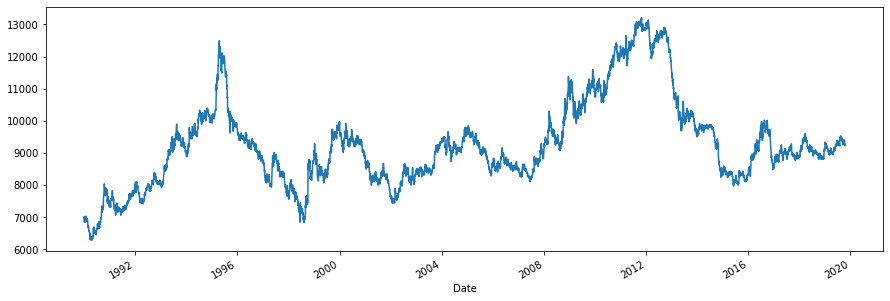

In [5]:
# Plot just the "Settle" column from the dataframe:
yen_futures['Settle'].plot(figsize=(15, 5))

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [6]:
# Import statsmodel api to access Hodrick-Prescott filter function
import statsmodels.api as sm
# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
yen_noise, yen_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])

In [7]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
# Renamed the columns as noise and trend
yen_df = pd.concat([yen_futures['Settle'], yen_noise, yen_trend], axis='columns', join='inner')
yen_df = yen_df.rename(columns={'Settle_cycle': 'noise', 'Settle_trend': 'trend'})
yen_df.head()

,Settle,noise,trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


In [8]:
# Settle Price vs. the Trend for 2015 to the present (10/15/2019 has the last entry in yen data)
yen_2015_2019_df = yen_df.loc['2015':'2019', :]
yen_2015_2019_df.tail()

,Settle,noise,trend
Date,,,
2019-10-09,9338.0,24.939247,9313.060753
2019-10-10,9303.5,-5.868559,9309.368559
2019-10-11,9251.0,-54.454594,9305.454594
2019-10-14,9265.0,-36.423060,9301.423060
2019-10-15,9221.5,-75.844123,9297.344123


<AxesSubplot:title={'center':'Yen - Settle vs Trend'}, xlabel='Date'>

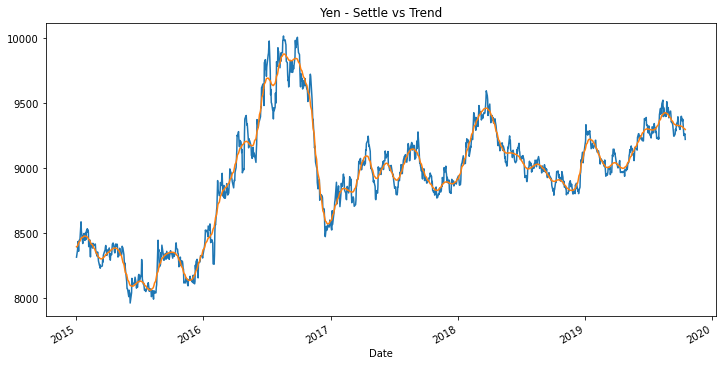

In [9]:
# Plot 2015 to 2019 yen Settle vs. trend data
yen_2015_2019_df.Settle.plot(figsize=(15, 5), title= 'Yen - Settle vs Trend')
yen_2015_2019_df.trend.plot(figsize=(12, 6))

<AxesSubplot:title={'center':'Noise'}, xlabel='Date'>

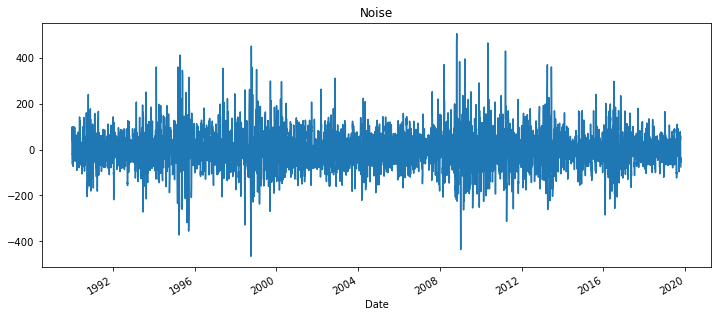

In [10]:
# Plot yen noise using the original dataframe (1990 to present)
yen_df.noise.plot(figsize=(12, 5), title= 'Noise')

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [11]:
# We are going to leverage ADFULLER function of statsmodels to determine P values. 
# PLus added perform_adf_test function to showcase only ADF and P-value from ADFULLER values.
from statsmodels.tsa.stattools import adfuller
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result [0])
    print('p-value: %f' % result[1])

In [12]:
# Run ADF test to check the P value (optimal P-value is less than 0.05, alpha). 
# Data is non-stationary with P-value over desirable 0.05. This data is non-stationary
perform_adf_test(yen_futures.Settle)

ADF Statistic: -2.415125
p-value: 0.137513


In [13]:
# Create series using "Settle" price percentage returns, drop any nan"s, 
# and check the results:(Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [14]:
# import ARMA model from statsmodels
from statsmodels.tsa.arima_model import ARMA

# Estimate Arma model using yen returns (use order=(2, 1) 2 for AR-P and 1 for MA-Q)
model1 = ARMA(returns.values, order=(2, 1))

# Fit the model and assign it to a variable called result1 - I am using model1 and result1
# naming conventions to distinguish other models below
result1 = model1.fit()

In [15]:
# Output model summary results: while comparing different models, lower AIC and BIC values are desirable
# plus P>|Z| value should be less than alpha (0.05). Here results are not optimal
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Thu, 07 Oct 2021   AIC                          15798.142
Time:                        14:30:49   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0064      0.008      0.804      0.421      -0.009       0.022
ar.L1.y       -0.3061      1.278     -0.240      0.811      -2.810       2.198
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2945      1.278      0.231      0.818      -2.210       2.799
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3363           +0.0000j            3.3363            0.5000
AR.2         -157.2002           +0.0000j          157.2002            0.5000
MA.1           -3.3953           +0.0000j            3.3953            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'Yen Forecast'}>

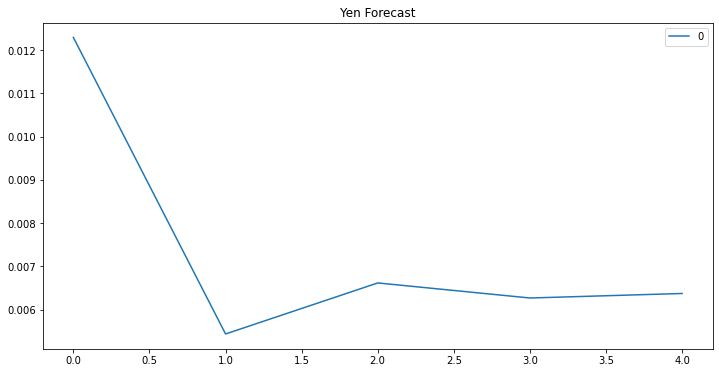

In [16]:
# Plot the 5 Day Returns Forecast using forecast steps 5
pd.DataFrame(result1.forecast(steps=5)[0]).plot(figsize=(12, 6), title="Yen Forecast")

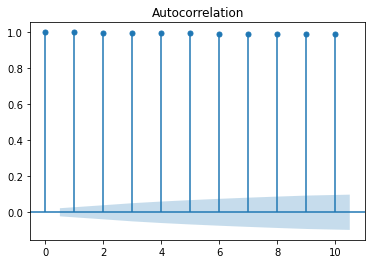

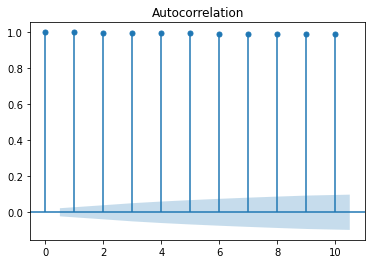

In [17]:
# As we discussed in our class session, changing hyperparameter will change the accuracy of the model.
# To figure out the right AR(lag) and MA(error), I will plot autocorrelation and partial-autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(yen_futures.Settle, lags=10)

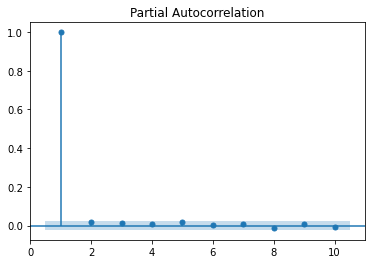

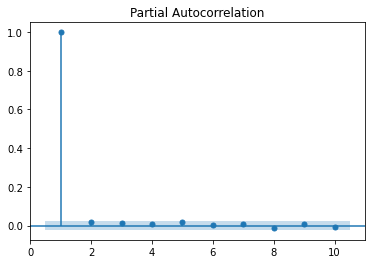

In [18]:
plot_pacf(yen_futures.Settle, zero=False, lags=10)

In [19]:
# We could use any lag between 1 - 10 from autocorrelation map above. Since there isn't much separation,
# I discovered the best results using lag 1. Plus decreasing variable(coefficient) feature is always beneficial.
# Here, I will rerun the ARMA model using .diff instead of .pct_change (Like above, 
# plus change the order). In the summary below, P>|z| values are optimal 
returns_dif = (yen_futures[["Settle"]].diff() * 100)
returns_dif = returns.replace(-np.inf, np.nan).dropna()

model_opt = ARMA(returns_dif.values, order=(1, 1))

result_opt = model_opt.fit()
result_opt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(1, 1)   Log Likelihood               -7893.399
Method:                       css-mle   S.D. of innovations              0.692
Date:                Thu, 07 Oct 2021   AIC                          15794.798
Time:                        14:30:51   BIC                          15822.496
Sample:                             0   HQIC                         15804.309
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.830      0.406      -0.009       0.021
ar.L1.y        0.6985      0.188      3.712      0.000       0.330       1.067
ma.L1.y       -0.7112      0.185     -3.850      0.000      -1.073      -0.349
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4317           +0.0000j            1.4317            0.0000
MA.1            1.4061           +0.0000j            1.4061            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'Yen Forecast'}>

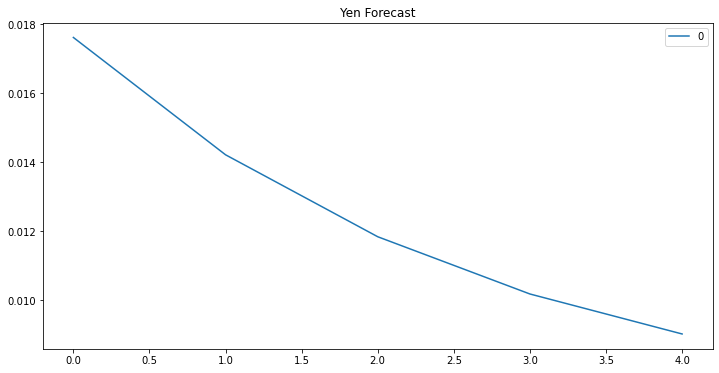

In [20]:
# Plot the 5 Day Returns Forecast using setps 5 
pd.DataFrame(result_opt.forecast(steps=5)[0]).plot(figsize=(12, 6), title="Yen Forecast")

# Takeaways
### In the above summary of second model using (1, 1) order, P values(0.0000 -AR lag, 0.0000 - MA error) are better than the ARMA model with order (2, 1). Returns prediction seems consistent as well in the second model, and it forecasts yen returns regularly going down for next 5 days.

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [21]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model2 = ARIMA(yen_futures.Settle.values, order=(5, 1, 1))
# Fit the model
result2 = model2.fit()

In [22]:
# Output model summary results:
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Thu, 07 Oct 2021   AIC                          83905.238
Time:                        14:30:52   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3161      0.700      0.452      0.652      -1.056       1.688
ar.L1.D.y      0.2827      0.699      0.405      0.686      -1.087       1.652
ar.L2.D.y      0.0007      0.016      0.043      0.965      -0.030       0.032
ar.L3.D.y     -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.y     -0.0136      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.y     -0.0011      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.y     -0.2977      0.699     -0.426      0.670      -1.667       1.072
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8924           -1.3781j            2.3410           -0.1002
AR.2            1.8924           +1.3781j            2.3410            0.1002
AR.3           -2.2728           -3.0189j            3.7788           -0.3527
AR.4           -2.2728           +3.0189j            3.7788            0.3527
AR.5          -11.1644           -0.0000j           11.1644           -0.5000
MA.1            3.3587           +0.0000j            3.3587            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Futrue Price Forecast using ARIMA'}>

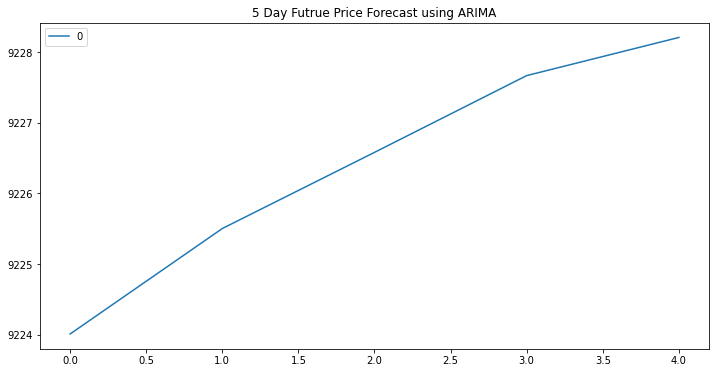

In [23]:
# Plot the 5 Day Price Forecast
pd.DataFrame(result2.forecast(steps=5)[0]).plot(figsize=(12, 6), title="5 Day Futrue Price Forecast using ARIMA")

# Takeaways
### With ARIMA calculations order of (5,1,1), ARIMA model performed poorly compared to ARMA models (ARMA model with P, Q order of (1, 1) was the best model)
### Both AIC and BIC values are much higher than ARMA Model. P-values are very inconsistent, and are above desired alpha value of 0.05.


---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [24]:
# We have to pip install arch to successfully run GARCH model
#!pip install arch
from arch import arch_model

In [25]:
# Estimate a GARCH model: 
model3 = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
result3 = model3.fit(disp="off")

In [26]:
# Summarize the model results
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Thu, Oct 07 2021   Df Residuals:                     7514
Time:                        14:30:53   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.707e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [27]:
# Find the last day of the dataset and format the date for forecast usage 
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [28]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts = result3.forecast(start=last_day, horizon=forecast_horizon)
forecasts.variance

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
1990-01-03,NaN,NaN,NaN,NaN,NaN
1990-01-04,NaN,NaN,NaN,NaN,NaN
1990-01-05,NaN,NaN,NaN,NaN,NaN
1990-01-08,NaN,NaN,NaN,NaN,NaN
1990-01-09,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2019-10-09,NaN,NaN,NaN,NaN,NaN
2019-10-10,NaN,NaN,NaN,NaN,NaN
2019-10-11,NaN,NaN,NaN,NaN,NaN


In [29]:
# Annualize the forecast, drop nas. plus rename the forecast columns 
intermediate = np.sqrt(forecasts.variance.dropna() * 252) 
intermediate.rename(columns={'h.1': 'Day 1', 'h.2': 'Day 2', 
                             'h.3': 'Day 3', 'h.4': 'Day 4','h.5': 'Day 5'}, inplace= True)
intermediate.head()

,Day 1,Day 2,Day 3,Day 4,Day 5
Date,,,,,
2019-10-15,7.434032,7.475729,7.516851,7.55741,7.597418


In [30]:
# Transpose the forecast so that it is easier to plot (Columns to rows)
final = intermediate.dropna().T
final.head()

Date,2019-10-15
Day 1,7.434032
Day 2,7.475729
Day 3,7.516851
Day 4,7.557410
Day 5,7.597418


<AxesSubplot:title={'center':'Five Days Volatility Forecast using GARCH Model'}, xlabel='Forecast Start Date:    2019-10-15', ylabel='Forecast Annual Square Root Variance'>

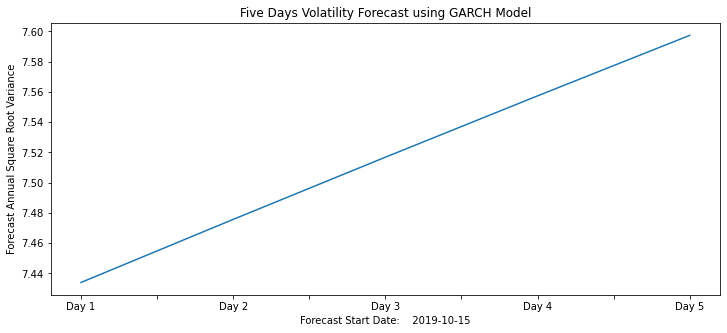

In [31]:
# Plot the final forecast and set the parameters
final.plot(figsize=(12, 5), title = "Five Days Volatility Forecast using GARCH Model",
                xlabel = 'Forecast Start Date:    2019-10-15', 
                ylabel ='Forecast Annual Square Root Variance', legend=False)

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

## Takeaways
- GARCH model's alpha[1] P-value is 0.00, which is better than alpha (less than 0.05). Hence GARCH volatility model is optimal to predict risk levels for Yen short term (5 days) investment. 
  
- Yen five days volatility forecast, using GARCH Model, shows higher volatility. Risk is expected to increase for next 5 days. 

- Yes, I feel confident in using above models for trading.
